# Identifying Yoga Poses

We've collected a few samples for each pose we'd like to categorize, and we need to learn how to identify which pose the user is in. We first used our tflite convolutional pose machine model to obtain a graphical representation of the poses we collected. This will produce a 28 point array of the various body part coordinates in each sample. We'll save this array along with its correct pose label to construct a dataset. First, let's import all the libraries we'll be using.

In [1]:
%matplotlib inline

import pickle
import multiprocessing
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Let's load our data and take a peak at what those samples look like.

In [2]:
dataset = pd.read_csv('./data/yoga/poses.csv', index_col=0)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,57.0,84.0,61.0,72.0,53.0,68.0,37.0,64.0,25.0,64.0,...,32.0,85.0,16.0,77.0,48.0,81.0,36.0,89.0,16.0,plank
1,57.0,84.0,61.0,72.0,53.0,68.0,37.0,64.0,25.0,64.0,...,32.0,85.0,16.0,77.0,48.0,81.0,36.0,89.0,16.0,plank
2,52.0,84.0,56.0,72.0,48.0,68.0,32.0,64.0,20.0,64.0,...,32.0,80.0,16.0,72.0,48.0,76.0,36.0,84.0,16.0,plank
3,52.0,79.0,56.0,67.0,48.0,63.0,32.0,59.0,20.0,59.0,...,27.0,80.0,11.0,72.0,43.0,76.0,31.0,84.0,11.0,plank
4,59.0,84.0,63.0,72.0,55.0,68.0,39.0,64.0,27.0,64.0,...,32.0,87.0,16.0,79.0,48.0,83.0,36.0,91.0,16.0,plank


Format the data so we can feed it to a model.

In [3]:
# Spliting the points and the labels
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, 28].values

# And split the data into appropriate data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

In [4]:
class_names = list(set(y))
num_class = len(class_names)
cores = multiprocessing.cpu_count()

Our data is ready to feed it to a model! Our first approach will be to classify which pose the user is currently in. If the user is not in the correct pose, we'll give them some advice on how to execute it. As we progress, we'll want to think about how to evaluate the user's pose, ie. how well are they execuring the pose. But for now, let's just determine if a user is in the right pose.

We'll try XGBoost. This algorithm is an implementation of gradient boosted decision trees. It ensembles many decision trees into one model - making it more accurate as a collection of trees.

XGBoost is very fast and it has more parameters to tune to improve the model. Feel free to pay with the learning_rate, n_estimators, etc to get better results. Also keep in mind that more data never hurts.

In [5]:
clf = XGBClassifier(max_depth=6, 
                    learning_rate=0.01, 
                    n_estimators=500, 
                    objective='multi:softmax', 
                    n_jobs=cores, 
                    num_class=num_class)

In [6]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

/home/funk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We can see how well the model is grouping samples by printing the confusion matrix of the model. The confusion matrix will show us how often the model gets confused about a sample and misclassifies it AND to what it misclassifies.

We'll also look at the classification report which will give us the recall and precision among other stats for each label

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)

class_report = classification_report(y_test, preds)
print(class_report)

[[280   9   4   3   0  47   2   3  12   6  19]
 [ 10 282   4   0   0   3   4   3  10   0  10]
 [  6   7 181   0   0   6   1   1  11   2   7]
 [  3   0   0  61   0   0   2   0  50   4   5]
 [  4   0   0   0 135   2   0   5   5   0   9]
 [ 31   7   4   0   0 273   0   5   2   0   8]
 [  0   0   0   1   0   1  88   1  20   5   2]
 [  2   0   0   0   2   7   0 218  14   3   2]
 [ 14   7   6   9   1   2   4   3 249  63  61]
 [  5   5   0   1   1   4   3  15  51 288  21]
 [ 15   4   0   1   3  19   5   7  55  42 264]]
                      precision    recall  f1-score   support

chaturanga_dandasana       0.76      0.73      0.74       385
               cobra       0.88      0.87      0.87       326
                 cow       0.91      0.82      0.86       222
      crescent_lunge       0.80      0.49      0.61       125
           half_moon       0.95      0.84      0.89       160
               plank       0.75      0.83      0.79       330
           tree_pose       0.81      0.75      

And to get a better view let's graph the confusion matrix.

In [8]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

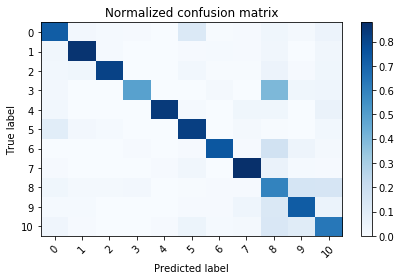

Classes:  ['chaturanga_dandasana', 'cobra', 'cow', 'crescent_lunge', 'half_moon', 'plank', 'tree_pose', 'triangle', 'warrior_1', 'warrior_2', 'warrior_3']


In [9]:
plot_confusion_matrix(conf_matrix, classes=sorted(class_names), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('Classes: ', sorted(class_names))

Dark blue on the diagonal is what we're aiming for. We can see the model is really good at predicting tree_pose but warrior_1 gets confused with crescent_lunge and warrior_3 poses. However, this is a great start classifying a handful of distinct poses. We want to save the model to file so we can run inference while our virtual instructor is running.

In [10]:
filename = './models/yoga_poses.sav'
pickle.dump(clf, open(filename, 'wb'))